# Systematic Literature Review DX in Shipping - Concept Trends

Note: We can only do thematic analysis on title, since for the abstract we have inverted abstract and we are not capable of properly rebulding it

In [3]:
#!pip install spacy

In [4]:
#!python -m spacy download en_core_web_md

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from collections import Counter

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import DocBin

from gensim import corpora
from gensim.models import LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer

from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Read the DB in

In [3]:
# Read in the file
#lit = pd.read_csv('C:/projects/dx_in_shipping/openalex_data_final.csv')
lit = pd.read_csv('./openalex_data.csv',low_memory=False)

In [4]:
# This cell is useful to check columns in the db. To be used only after having loaded the pandas df
substring = 'concepts'
# # List all column names containing the substring using list comprehension
test = [k for k in lit.columns if substring in k]
print(test)

['concepts_0_id', 'concepts_0_wikidata', 'concepts_0_display_name', 'concepts_0_level', 'concepts_0_score', 'concepts_1_id', 'concepts_1_wikidata', 'concepts_1_display_name', 'concepts_1_level', 'concepts_1_score', 'concepts_2_id', 'concepts_2_wikidata', 'concepts_2_display_name', 'concepts_2_level', 'concepts_2_score', 'concepts_3_id', 'concepts_3_wikidata', 'concepts_3_display_name', 'concepts_3_level', 'concepts_3_score', 'concepts_4_id', 'concepts_4_wikidata', 'concepts_4_display_name', 'concepts_4_level', 'concepts_4_score', 'concepts_5_id', 'concepts_5_wikidata', 'concepts_5_display_name', 'concepts_5_level', 'concepts_5_score', 'concepts_6_id', 'concepts_6_wikidata', 'concepts_6_display_name', 'concepts_6_level', 'concepts_6_score', 'concepts_7_id', 'concepts_7_wikidata', 'concepts_7_display_name', 'concepts_7_level', 'concepts_7_score', 'concepts_8_id', 'concepts_8_wikidata', 'concepts_8_display_name', 'concepts_8_level', 'concepts_8_score', 'concepts_9_id', 'concepts_9_wikidat

In [7]:
# This cell is useful to check columns in the db. To be used only after having loaded the pandas df
substring = 'concepts'
substring2 = '_display_name'
# # List all column names containing the substring using list comprehension
matching_columns = [k for k in lit.columns if substring in k and substring2 in k]
print(matching_columns)
# #lit['title']

['concepts_0_display_name', 'concepts_1_display_name', 'concepts_2_display_name', 'concepts_3_display_name', 'concepts_4_display_name', 'concepts_5_display_name', 'concepts_6_display_name', 'concepts_7_display_name', 'concepts_8_display_name', 'concepts_9_display_name', 'concepts_10_display_name', 'concepts_11_display_name', 'concepts_12_display_name', 'concepts_13_display_name', 'concepts_14_display_name', 'concepts_15_display_name', 'concepts_16_display_name', 'concepts_17_display_name', 'concepts_18_display_name', 'concepts_19_display_name', 'concepts_20_display_name', 'concepts_21_display_name', 'concepts_22_display_name', 'concepts_23_display_name', 'concepts_24_display_name', 'concepts_25_display_name', 'concepts_26_display_name', 'concepts_27_display_name', 'concepts_28_display_name', 'concepts_29_display_name', 'concepts_30_display_name', 'concepts_31_display_name', 'concepts_32_display_name', 'concepts_33_display_name', 'concepts_34_display_name']


In [8]:
# we want to get now a lit['year'] with the proper publication year and a lit['concepts'] with list of concepts for that paper
def findConceptList(limit_to_concept_level_min,limit_to_concept_level_max): # values 0,1,2,3,4,5
    concept_list = {}
    p_year = {}
    for index, row in lit.iterrows():
        p_year[row['id']] = pd.to_datetime(row['publication_date']).year 
        for c in matching_columns:        
            if not pd.isnull(row[c]):
                c_level = row[c.replace('_display_name', '_level')]        
                if (c_level >= limit_to_concept_level_min and c_level <= limit_to_concept_level_max):
                    if not row['id'] in concept_list:                
                        concept_list[row['id']] = []
                        concept_list[row['id']].append(row[c])
                    else:
                        concept_list[row['id']].append(row[c])
    return concept_list, p_year

# # Normalize concepts (split semicolon-separated strings into lists if necessary)
# lit['concepts'] = lit['concepts'].str.lower().str.split(';')  # Adjust delimiter as needed

# # Remove NaN or empty concept entries
# lit = lit[lit['concepts'].notna()]

In [79]:
def findConceptListWithFilter(limit_to_concept_level_min,limit_to_concept_level_max,filterList): # values 0,1,2,3,4,5
    concept_list = {}
    p_year = {}
    for index, row in lit.iterrows():
        p_year[row['id']] = pd.to_datetime(row['publication_date']).year 
        for c in matching_columns:        
            if not pd.isnull(row[c]):                
                c_level = row[c.replace('_display_name', '_level')]       
                if (c_level >= limit_to_concept_level_min and c_level <= limit_to_concept_level_max):
                    if (row[c] in filterList):
                        if not row['id'] in concept_list:
                            concept_list[row['id']] = []
                            concept_list[row['id']].append(row[c])
                        else:
                            concept_list[row['id']].append(row[c])
    return concept_list, p_year

In [47]:
# prepare new dataset
# Ensure both dictionaries share the same keys
concept_list = concept_list_0
p_year = p_year_0
common_ids = set(p_year.keys()) & set(concept_list.keys())

# Create the DataFrame
data = pd.DataFrame({
    'id': list(common_ids),
    'year': [p_year[id] for id in common_ids],
    'concepts': [concept_list[id] for id in common_ids]
})

In [63]:
# Frequency analysis of topics

# Aggregate concepts by year
concepts_by_year = data.groupby('year')['concepts'].sum()  # Combine concept lists by year

# Count concept frequencies for each year
concept_trends = pd.DataFrame([
    Counter(year_concepts) for year_concepts in concepts_by_year
]).fillna(0)

# Add years as a column
concept_trends.index = concepts_by_year.index  # Year as the index
concept_trends.reset_index(inplace=True)
concept_trends.rename(columns={'index': 'Year'}, inplace=True)

# Remove columns that contain only zeros
concept_trends = concept_trends.loc[:, (concept_trends != 0).any()]

print(concept_trends)

    year  Engineering  Computer science  Business  Economics  Philosophy  \
0   1966          1.0               1.0       1.0        1.0         1.0   
1   1967          1.0               1.0       0.0        0.0         0.0   
2   1968          1.0               0.0       1.0        1.0         0.0   
3   1977          2.0               2.0       0.0        0.0         0.0   
4   1979          1.0               1.0       0.0        0.0         0.0   
5   1981          0.0               0.0       0.0        0.0         0.0   
6   1989          0.0               1.0       0.0        0.0         0.0   
7   1991          1.0               1.0       1.0        0.0         0.0   
8   1992          2.0               1.0       2.0        1.0         2.0   
9   1994          1.0               0.0       1.0        1.0         0.0   
10  1996          1.0               1.0       0.0        0.0         0.0   
11  1998          0.0               0.0       0.0        0.0         0.0   
12  1999    

Index(['Computer science', 'Engineering', 'Business', 'Biology', 'Mathematics',
       'Physics', 'Economics', 'Geography', 'Political science',
       'Environmental science', 'Geology', 'Philosophy', 'Chemistry',
       'Medicine', 'Sociology', 'Psychology', 'Art', 'Materials science',
       'History'],
      dtype='object')
     year            Concept  Frequency
0    2001        Engineering        0.0
1    2002        Engineering        0.0
2    2003        Engineering        1.0
3    2004        Engineering        2.0
4    2005        Engineering        3.0
..    ...                ...        ...
451  2020  Materials science        6.0
452  2021  Materials science        7.0
453  2022  Materials science       10.0
454  2023  Materials science        8.0
455  2024  Materials science       11.0

[456 rows x 3 columns]


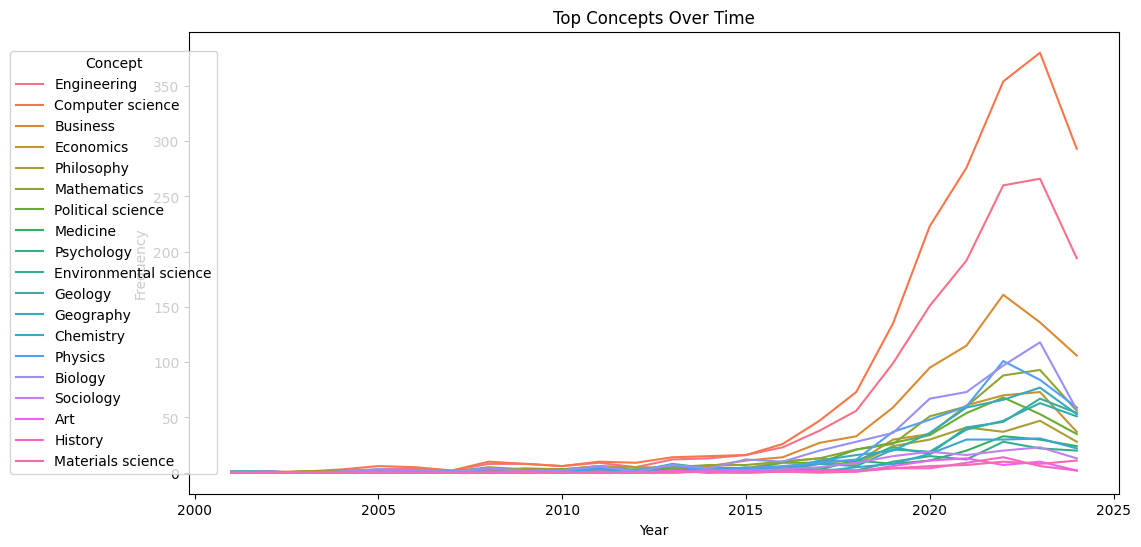

In [65]:
# Get the top N concepts overall
# filter on recent years if needed
year_min = 2000
concept_trends_ylim = concept_trends[concept_trends['year'] >= year_min]

N = 40
top_concepts = concept_trends_ylim.iloc[:, 1:].sum().sort_values(ascending=False).head(N).index
print(top_concepts)

# Melt data for plotting
trend_melted = concept_trends_ylim.melt('year', var_name='Concept', value_name='Frequency')
trend_melted = trend_melted[trend_melted['Concept'].isin(top_concepts)]  # Filter top concepts

print(trend_melted)

# Plot trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_melted, x='year', y='Frequency', hue='Concept')
plt.title('Top Concepts Over Time')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(
    title='Concept',
    loc='center left',  # Position relative to the chart
    bbox_to_anchor=(-0.2, 0.5),  # Move legend to the left outside the plot area
    borderaxespad=0.5
)
plt.show()

In [ ]:
concept_list_1, p_year_1 = findConceptListWithFilter(1,1,selected_concepts) # selected_concept is defined later
concept_list_2, p_year_2 = findConceptListWithFilter(2,2,selected_concepts)
concept_list_3, p_year_3 = findConceptListWithFilter(3,3,selected_concepts)
concept_list_4, p_year_4 = findConceptListWithFilter(4,4,selected_concepts)
concept_list_5, p_year_5 = findConceptListWithFilter(5,5,selected_concepts)

Index(['Artificial intelligence', 'Computer security', 'Operating system',
       'Mechanical engineering', 'Telecommunications', 'Marketing',
       'Electrical engineering', 'Operations research', 'Machine learning',
       'Data mining'],
      dtype='object')
     year              Concept  Frequency
96   2001  Operations research        0.0
97   2002  Operations research        0.0
98   2003  Operations research        0.0
99   2004  Operations research        0.0
100  2005  Operations research        1.0
..    ...                  ...        ...
811  2020     Machine learning       28.0
812  2021     Machine learning       47.0
813  2022     Machine learning       65.0
814  2023     Machine learning       87.0
815  2024     Machine learning       43.0

[240 rows x 3 columns]


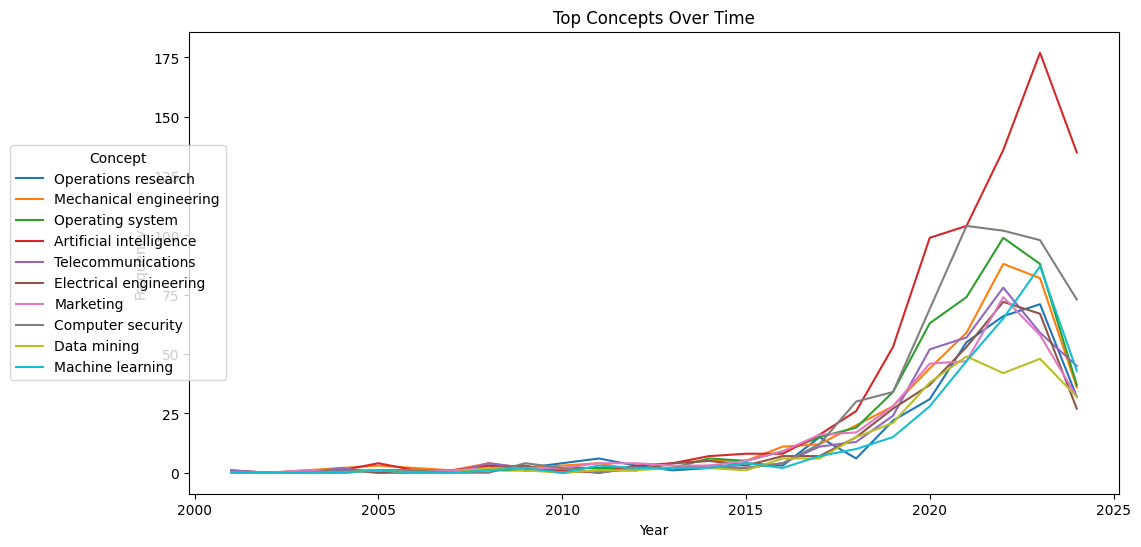

In [111]:
# prepare new dataset
# Ensure both dictionaries share the same keys
concept_list = concept_list_1
p_year = p_year_1
common_ids = set(p_year.keys()) & set(concept_list.keys())

# Create the DataFrame
data = pd.DataFrame({
    'id': list(common_ids),
    'year': [p_year[id] for id in common_ids],
    'concepts': [concept_list[id] for id in common_ids]
})

# Frequency analysis of topics

# Aggregate concepts by year
concepts_by_year = data.groupby('year')['concepts'].sum()  # Combine concept lists by year

# Count concept frequencies for each year
concept_trends = pd.DataFrame([
    Counter(year_concepts) for year_concepts in concepts_by_year
]).fillna(0)

# Add years as a column
concept_trends.index = concepts_by_year.index  # Year as the index
concept_trends.reset_index(inplace=True)
concept_trends.rename(columns={'index': 'Year'}, inplace=True)

# Remove columns that contain only zeros
concept_trends = concept_trends.loc[:, (concept_trends != 0).any()]

# Get the top N concepts overall
# filter on recent years if needed
year_min = 2000
concept_trends_ylim = concept_trends[concept_trends['year'] >= year_min]

N = 10
top_concepts = concept_trends_ylim.iloc[:, 1:].sum().sort_values(ascending=False).head(N).index
print(top_concepts)

# Melt data for plotting
trend_melted = concept_trends_ylim.melt('year', var_name='Concept', value_name='Frequency')
trend_melted = trend_melted[trend_melted['Concept'].isin(top_concepts)]  # Filter top concepts

print(trend_melted)

# Plot trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_melted, x='year', y='Frequency', hue='Concept')
plt.title('Top Concepts Over Time')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(
    title='Concept',
    loc='center left',  # Position relative to the chart
    bbox_to_anchor=(-0.2, 0.5),  # Move legend to the left outside the plot area
    borderaxespad=0.5
)
plt.show()

In [101]:
selected_concepts = ['Engineering physics','Construction engineering','Process management','Automotive engineering','Mechanical engineering','Algorithm','Industrial engineering','Electronic engineering','Multimedia','Database','Internet privacy','Natural language processing','Data science','Embedded system','Artificial intelligence','Real-time computing','Distributed computing','Computer hardware','Software engineering','Engineering drawing','Operations management','Transport engineering','Control engineering','Architectural engineering','Environmental engineering','Agricultural engineering','Structural engineering','Theoretical computer science','Nuclear engineering','Computer architecture','Computer graphics (images)','Biomedical engineering','Pulp and paper industry','Civil engineering','Management science','Engineering management','Forensic engineering','Library science','Mining engineering','Simulation','Telecommunications','Operating system','World Wide Web','Parallel computing','Systems engineering','Waste management','Computational science','Manufacturing engineering','Information retrieval','Computer security','Knowledge management','Computer vision','Data mining','Speech recognition','Operations research','Marine engineering','Reliability engineering','Computer engineering','Programming language','Human‚Äìcomputer interaction','Computer network','Engineering ethics','Petroleum engineering','Aeronautics','Machine learning','Chemical engineering','Process engineering','Geotechnical engineering','Electrical engineering','Aerospace engineering','Biochemical engineering','Load factor','Connection (principal bundle)','Roundness (object)','Coffee ring effect','Mechatronics','Choke','Ferrite (magnet)','Gas-filled tube','Pressure coefficient','Integrated logistics support','Mutual exclusion','Inflatable','Diplexer','Chebyshev filter','Wrench','Crossbar switch','Dashboard','Nanofiber','Network analyzer (electrical)','Reflection coefficient','CMOS','Code division multiple access','Servo','Geomembrane','Blanking','Fracture mechanics','Water balance','Extractor','Root cause analysis','Expediting','Unit load','Shaping','Iterative and incremental development','Residual risk','Mortise and tenon','SPHERES','Glider','Inviscid flow','Blueprint','Failure rate','EPROM','Level sensor','Stereotype (UML)','Adaptive filter','Pore water pressure','Pillar','Lateral strain','Abrasion (mechanical)','Hydrophobe','Trap (plumbing)','Transition point','Ground pressure','COBOL','Coupling (piping)','Natural computing','Concept class','Bulk cargo','Civil engineering software','Nut','Automotive industry','Soft chemistry','User requirements document','Situation awareness','Honing','Mach number','Traffic volume','Industrial and production engineering','Harmonic drive','Polybutylene succinate','Reactor pressure vessel','CAD','Nova (rocket)','Bobbin','Spring steel','The Thing','Public disclosure','Electric utility','Red Color','Blackboard (design pattern)','Biomaterial','Overtaking','Bumping','Fuel pump','Punching','Cross laminated timber','Splint (medicine)','Interlocking','Stairs','Contouring','Interactive programming','Stereolithography','Ground transportation','Parking lot','Stearic acid','Earth materials','Landing gear','Climb','Sprayer','Crushed stone','Space frame','Organosilicon','Ammonium fluoride','Air compressor','Shoring','Rapid prototyping','Unavailability','NIMBY','Raising (metalworking)','Virtual prototyping','Oil pressure','BATES','Triple play (telecommunications)','Mechanical compression','Inclination angle','Air transport','Monitoring and control','Seismic resistance','Railway line','Scientific integrity','Channel tunnel','Material balance','Oil storage','Fracturing fluid','Metro station','Ground movement','Arrival time','Heavy traffic','Injection site','Potable water','Roller coaster','Displacement method','Single stage','Water disinfection','Control room','Buoy','Public consultation','Backup','Tray','Time limit','System-level simulation','Neural Prosthesis','Risk prevention','Delivery system','Industrial equipment','Flow chart','Work flow','Benefit analysis','Digital computer','Internal forces','High speed train','Execution time','Fire safety','Free water','Work safety','Rail transit','Contact theory','Nuclear science','Hydraulic pressure','Limited resources','Organic solvent','Package design','Insulator (electricity)','Thermal power station','Land use','Atmospheric entry','Environmental control system','Cupola','Electrical impedance','Deliverable','Telecommunications engineering','Implementation','Claw','Horizontal plane','Spin (aerodynamics)','Floor area ratio','Distribution management system','Structured programming','Electronic component','Time constant','Warm front','Metamodeling','Matrix method','Electrical conduit','Filter (signal processing)','Stiffening','Outfall','Bolting','Automation','Transponder (aeronautics)','Fire protection','Fire test','Ballast','Penstock','Gear pump','Gate valve','Technical drawing','Prime mover','Spinning','Nanoparticle','Carton','Clipper (electronics)','Orthographic projection','Inductive coupling','Petroleum industry','Swash','Residence time (fluid dynamics)','Disperser','Slicing','Silicic acid','Slider','Chemiresistor','Brickwork','Calcium carbonate','Vibrating wire','Seawall','Safety factor','Transition system','Tape recorder','Caprolactam','Turbo generator','Kansei engineering','Barium hydroxide','Electromagnetics','Electromagnetic simulation','Oil production','Fatigue testing','Transfer efficiency','Master plan','Ethical values','Gas analysis','Chemical agents','Propulsion','Arc lamp','Dispersity','Project management','Core network','Porosity','Drive shaft','Circulation (fluid dynamics)','Buttress','Limit state design','Nyquist‚ÄìShannon sampling theorem','Delta','Breadboard','Space Science','Seismic microzonation','Filter paper','Resin acid','Suction','Relief valve','Warning system','Casing','Horizontal position representation','Hydropower','Gigabit','Radial Force Variation','Lateral earth pressure','Design rationale','Structural element','Avionics','Wiring diagram','Sol-gel','Substitution method','Pressure sensor','Magnet','Storage tank','Tap water','Hybrid computer','Residual strength','Drilling','Front and back ends','Thermogravimetric analysis','Intersection (aeronautics)','Polygraph','Nuclear reactor core','Photovoltaic system','Fuel efficiency','Intelligent transportation system','Abutment','Network synthesis filters','Thermistor','Stripline','Compressibility','Wind tunnel','Nanosheet','Fold (higher-order function)','Statically indeterminate','Fault tolerance','Sanitary engineering','Asphaltene','Receptacle','Camber (aerodynamics)','Remotely operated vehicle','Oriented strand board','Static random-access memory','Building science','Aviation','Butterfly valve','Configuration Management (ITSM)','Butt joint','Water supply','Siemens','Involute','Servomotor','Safety assurance','Seismic loading','Getter','Logic gate','Corrugated fiberboard','Joule heating','Pile','Refrigerator car','Kirkendall effect','Electric power transmission','Single displacement reaction','Cryopump','Synchronous motor','Diode','Inertial measurement unit','Dissolution','Notching','Petrochemical','Spiral (railway)','Light-emitting diode','cardboard','Quasistatic loading','Airframe','Landscape architecture','Energy conversion efficiency','3D printing','Electrostatic precipitator','Automobile handling','Bernoulli s principle','Impeller','Traceability','Perovskite (structure)','Structural rigidity','Static pressure','Slag (welding)','Toe','NASA Chief Scientist','Dynamic balance','Micrometer','Phase noise','Skid (aerodynamics)','Membrane computing','Estimation','Substructure','Blackwater','Cabin pressurization','Zipper','Shock absorber','Cable gland','Formal verification','Electrical element','Legal ethics','Digital radio','Traffic management','Cantilever','Packaging and labeling','Datalog','Parasitic extraction','Rigidity (electromagnetism)','Framing (construction)','Human error','Packed bed','Thermodynamic cycle','Electronic control unit','Control valves','Thermostat','Spare part','Juncture','Spatial planning','Vertical orientation','Rush hour','Seat belt','Market penetration','Conveyor belt','Takeoff','Traffic calming','Nail (fastener)','Preventive action','Career management','Water injection (oil production)','Toilet','Test fixture','Bone tissue','Reservoir simulation','TRAC','Headway','SCOOP','Punctuality','Link level','Digital Video Broadcasting','Chisel','Structural health monitoring','Alley','Orbiter','Development plan','One-Step','Chlorinated paraffins','Distributor','Aspirator','Cart','Flash-lamp','Waviness','Surface finishing','Diethanolamine','Aisle','Crutch','Wheeling','Integrated design','Anthraquinone','Dust collector','Asperity (geotechnical engineering)','Microsimulation','Electric heating','Spice','Natural circulation','Retractor','Governor','Headphones','Mobile radio','Pi calculus','Crude oil','Place making','Spur gear','Biological safety','Operation planning','Excess heat','Safe driving','Report writing','Desk','Sander','Critical design','Boss','Triethoxysilane','Machine control','Mineral wool','Bentonite','Reamer','Turbine','Swelling','LOOM','Revetment','Street network','Power steering','Maintenance actions','Electrosurgery','Splitter plate','Mosquito net','Spur','Hydraulic press','Polyvinylpyrrolidone','Sucker rod','Skyline','Diesel engine','Laying','Digital manufacturing','Prestressed concrete','Town centre','Tweezers','Marine safety','Bilateral symmetry','Mechanical design','City logistics','Gear tooth','Ground floor','Waste material','Push and pull','Seismic energy','Vertical axis','Separation process','Air current','Cushion','Rational planning model','Wire speed','Inert gas','Electromagnetic environment','Workstation','Space technology','Windage','Transient state','Broaching','Medium frequency','Static electricity','Geotechnical investigation','DOCK','Certificate','Air conditioning','Sonication','Construction industry','Road traffic','Process plant','Mass transport','Work time','Boundary line','Structural failure','Penetration rate','Chemical deposition','Heavy duty','Culvert','Nanorod','Pressure head','Seismic risk','Jitter','Electronics','Electrohydraulic servo valve','Burnout','Current (fluid)','Engraving','Transverse plane','Bin','Digital control','Drill','Adapter (computing)','Airport security','Cable modem','Tall oil','Calipers','8-bit','Technical management','Piezoresistive effect','Inlet','Caliber','Energy conservation','Energy technology','Manifold (fluid mechanics)','Lifting equipment','Isopropyl alcohol','Drop test','Hydroxide','Information display systems','Adaptive reuse','Carbonyl iron','Pneumatics','System integrity','Geotextile','Gas lift','Design‚Äìbuild','Water hammer','Sodium persulfate','Trailer','Tilt (camera)','Sodium silicate','LED display','Hearing aid','Pilot plant','Abrasive','Power station','Environmental tests','Failure causes','Graphene','Testbed','Retarder','Seeding','Traction (geology)','Stripping (fiber)','Degree Rankine','Strain gauge','Circuit breaker','Technical communication','Whirlwind','Dewatering','Transient response','Structural system','Confocal laser scanning microscopy','Keel','Coolant','Ultra high frequency','Frustum','Electric current','Scram','Logic programming','HYDROSOL','Gas compressor','Bearing capacity','Lean manufacturing','Design methods','Subdivision','Warhead','Trunking','Computability','Capital cost','Spectrum analyzer','Electrical equipment','Modeling and simulation','Beam (structure)','Seismogram','Shear wall','Glass fiber','Neutral plane','Reducing atmosphere','Plastic bag','Hydrostatic test','True quantified Boolean formula','Strength of materials','Drawing board','International Space Station','Lettering','Tearing','Printing press','Logistics center','Oil pump','Megaproject','Biocompatibility','Jumper','Fire prevention','Waterproofing','Cellular manufacturing','Formwork','Remanufacturing','Dodecanol','Burst mode (computing)','Road surface','Speed limit','Cutting tool','Urban rail transit','Water turbine','Foundry','Electrical shock','Public space','Production cost','Process industry','Blood clotting','Daylighting','Electromagnetic pulse','Temperature coefficient','EEPROM','Electric discharge in gases','Systems design','Jet engine','Gravity separation','Sounding rocket','Infrastructure planning','Technology system','Civil infrastructure','Internal rotation','Dry sand','Maritime safety','Air monitoring','Variable displacement pump','Pulmonary surfactant','Functional requirement','Digital sensors','Laminar flow','Advanced manufacturing','Health systems engineering','Ball valve','Propagation delay','Space Shuttle','Energy transfer','Twisted pair','Roundabout','Die (integrated circuit)','Slab','Frequency-hopping spread spectrum','Eddy current','Reachability','Research ethics','Satisfiability','Municipal or urban engineering','Truss','Schulze method','Unit operation','Particle size','Design load','Telephony','Guidance system','Supersonic speed','Grippers','Denaturation (fissile materials)','Calcium oxide','Gas generator','Operating cost','Rubbing','Access management','Silane','Homodyne detection','Hydraulic fracturing','Carriageway','Load management','Skylight','Vertical displacement','Lubricant','Loss and damage','Demolition','Tissue fluid','Incident report','Traffic system','Biological materials','General motors','Aero engine','Computer technology','Brain tissue','Water flow','Air cell','Urban construction','Shallow sea','Closed circuit','Child safety','Natural compound','Liquid paraffin','Electronic instrument','Labor cost','Engineering education','Rotation around a fixed axis','Rotor (electric)','Business system planning','Template method pattern','Airspeed','Axial symmetry','Sweep frequency response analysis','Modelica','Total air temperature','Fracture (geology)','Latency (audio)','Static timing analysis','Piezoelectricity','Production engineering','Fission products','Inclined plane','Winch','Wetting','Globe valve','Nanopore','Borehole','Surface acoustic wave','Netlist','Immittance','Jet fuel','Megabit','Heat sink','Airfield traffic pattern','Telecommunications equipment','Static testing','Check-in','Aviation fuel','500 kHz','Limelight','Heating system','Fleet management','Ceiling (cloud)','Observational equivalence','Apatite','Silo','Positioning technology','Post-occupancy evaluation','Electric locomotive','Sulfonic acid','Life-cycle cost analysis','Bottled water','Mass concrete','Yarn','Air cargo','Shake','Academic integrity','Sheet metal','Energy consumption','Physical test','Nano-','Tractor','Accident analysis','Rammed earth','Spike (software development)','SWORD','Shovel','Production efficiency','Mining industry','Network structure','High rise','Gas consumption','Bike sharing','Air blast','Pig skin','Coffee grounds','Persona','Lubricity','Lens (geology)','Compressed air','Generic programming','Product life-cycle management','Halogen lamp','Secondary air injection','SerDes','Marine technology','Synchro','Digital micromirror device','Dependency (UML)','Shear force','Watercraft','Cartridge','Tidal power','Horsepower','Retiming','Flight simulator','Propagation constant','Leader election','Transducer','Electrometer','Sewage','Epicenter','Node (physics)','Inherent safety','Data modeling','Application-specific integrated circuit','Enterprise life cycle','Fretting','Refrigeration','Mechanical fan','Location theory','Transfer function','Clamping','Renting','Construction site safety','Semiconductor memory','Solid-state','Measured depth','JAR','Shelf life','Design structure matrix','Buckling','Microporous material','Unit cost','Abstract machine','Refinement calculus','Fireproofing','Space time','Heat exchanger','Inductive sensor','Raw water','Expansion joint','Switchover','Proximity sensor','Top-down and bottom-up design','Combine harvester','Installation','Earthquake shaking table','Multivariable calculus','Time division multiple access','Computer Aided Design','Bulkhead (partition)','Tripod (photography)','Phase change','Forming processes','Design thinking','Public address system','Sewerage','Memristor','Information system','Mechanical system','Emphasis (telecommunications)','Solenoid','Specification language','Program Design Language','Toughened glass','Professional ethics','Public housing','Succinctness','Sprint','Roll forming','Servant','Shaft mining','Woodworking','Overhead line','Screw pump','Stirrup','Front (military)','S band','Nuts and bolts','Subsea','Tower','Flange','Curling','Tapping','Iron oxide','SOCKS','Geosynthetics','TRIZ','Near net shape','Piping','Vibrator (electronic)','Ammonium carbonate','Ornidazole','Nuclear fuel','Hirundo','Dibutyl phthalate','Countdown','Target acquisition','Insert (composites)','Airbag','Stroke (engine)','Seniority','Survivability','Tolerance analysis','Shutdown','Garden design','Weight lifting','Barn','Human-body model','Car sharing','Electronic systems','Cost analysis','Rail transportation','Radio communications','Marine transportation','Hang','Mobile telephone','Open water','Oil exploration','Electronic equipment','Fuel cycle','Task group','Source model','Electrical machinery','Subway station','Oil tank','Risk communication','Multi stage','Water area','Deep hole','Highway system','Industrial chemistry','Hand held','Special section','Block model','Drug industry','Gene technology','Bone structure','Seismic isolation','Radioactive fallout','Cost control','Semi automatic','Cost effectiveness','Road transport','Fully automatic','Production rate','Chemical plant','Water cooling','Invention','Antenna (radio)','Coiled tubing','Fail-safe','Telescopic cylinder','Load testing','Isolator','Astronautics','Pour point','Propellant','Dimensioning','Biplane','Polyphase system','Resonator','Rock mechanics','Sieve analysis','Universal design','Tipping point (physics)','Spatial disorientation','Ethical code','Pencil (optics)','Thread (computing)','Transmission electron microscopy','Ultrafine particle','Angle of repose','Process calculus','User-centered design','Thermocouple','Ground','Seven Management and Planning Tools','Steam injection','Electric motor','Plasma cutting','Open-pit mining','Extensometer','Indicator organism','Scattering parameters','Partial evaluation','Range (aeronautics)','Capacitive sensing','Rail freight transport','Environmental monitoring','Joist','Triethylene glycol','Unexpected events','Fluorocarbon','Polyethylene glycol','Tetraethyl orthosilicate','Ethylene glycol','Tube (container)','Oil well','Tandem','Electrocoagulation','Vehicle miles of travel','Overheating (electricity)','Bioactive glass','Washer','Dirt','Passivity','Completion (oil and gas wells)','Accident management','Safety case','Backpack','Computer-aided','Brake','Wet-milling','Humidifiers','Process analysis','Nuclear plant','Test site','Oil spill','Product line','High strength steel','Impact energy','Oil supply','Sea transport','Toxic gas','Parking space','Plant root','Mississippi delta','State of art','Dual mode','Tobacco leaf','Ice water','Indoor air quality','Glovebox','Smart grid','Design pattern','Liveness','Ultra-wideband','Catenary','Spacecraft','Network analysis','Hydrogeology','Feed forward','Functional programming','Plasticizer','Thermal stability','Cyclic stress','Access network','Rotary engine','Bending moment','Integrated circuit design','Maceration (sewage)','Constant false alarm rate','Shielded cable','Arc (geometry)','Back pressure','Flexible electronics','Cost estimate','LED lamp','UMTS frequency bands','Dynamometer','Aircraft maintenance','Lapping','Slope stability','Levee','Airflow','Construction management','Prognostics','Frequency standard','Ball mill','Electronic circuit','Polishing','Hotline','Speciality chemicals','Travel behavior','Geometric dimensioning and tolerancing','Effluent','Artificial bone','Rib cage','Wafer','Direct coupling','GRASP','Microcontroller','Evaporative cooler','Prospecting','Pipeline transport','Stratum','Nanocrystal','Monorail','Mass ratio','Busbar','Chassis','Public transport','Silicone oil','Open plan','Fiberboard','Dynamic loading','Dilator','Saddle','Aluminium silicate','Skinning','Urban village','Manufacturing cost','Cruise','Check valve','Urban culture','Strapping','City centre','Ground freezing','Car seat','V band','Carpool','Container (type theory)','Shell (structure)','Fixture','W band','Life cycle costing','Biological tissue','Rail traffic','Quantitative biology','Load bearing','Diesel locomotive','Hot plate','Contact system','Fuel supply','Research integrity','Shut down','Working environment','Level crossing','Gas oil ratio','Earthquake prediction','Maintenance engineering','Cascade','Circuit diagram','Prefabrication','Kilometer','Pink noise','Cathode','Process integration','Direct integration of a beam','Colloid','Embedment','Size effect on structural strength','DC motor','Behavioral modeling','Life support system','Hydroelectricity','Kraft paper','Earthquake engineering','Electrical phenomena','Spaceflight','Lightning arrester','Model checking','Boundary layer','Microstrip','Interdiction','Operating temperature','Acceptance testing','Pressure vessel','Economies of agglomeration','Bent molecular geometry','Fumed silica','Stove','Rope','Frieze','Honeycomb structure','Fan-in','Burn-in','Taxis','Reducing agent','Compaction','Booster (rocketry)','Glass production','Machining','Engine department','Masonry','Design history','Sodium-cooled fast reactor','Insulation system','Descent (aeronautics)','Backlash','Roof','Nesting (process)','Rifle','Side impact','Tissue repair','Cold forming','Brush','Buckle','Tamper resistance','Interrupter','Breakwater','PageRank','Trip distribution','Cellulose','Pyrolysis','Sill','Positive feedback','Servomechanism','Metalworking','Cabinet (room)','Miniaturization','Rivet','Caster','Ostwald ripening','Radiator (engine cooling)','Groundwater','Needs analysis','Behavioral pattern','Carrier system','Digital signal processing','Portable water purification','Nanocomposite','Wastewater','Production line','Turbofan','Systems modeling','Formal specification','Frame (networking)','Peristaltic pump','Phaser','Slosh dynamics','Urban economics','Footplate','Brick','Hydraulic head','Cage','Signal-flow graph','Microtechnology','X-ray photoelectron spectroscopy','Tensegrity','Method engineering','Lead‚Äìlag compensator','Boiling point','Water treatment','Informatics','Pressure system','Integrally closed','Integrated circuit','Optimal maintenance','Grading (engineering)','Light-water reactor','Comprehensive planning','Solution process','Urbanity','Transport network','CATS','Facade','Strip steel','Chemical resistance','Conveyor system','Built-in self-test','Transfer line','Deep drawing','Pressure control','Basement','Disruptive technology','Bit rate','Machine building','Railway tunnel','Nuclear radiation','Air purification','Degradation (telecommunications)','Low-cycle fatigue','Polyethylene terephthalate','Steering wheel','Headset','Diathermy','AutoLISP','Tube furnace','Tectorial membrane','Electric traction','High pressure','Stepper motor','Railway system','Materials processing','Electric cars','Transport system','Plant system','Amorphous silica','Passenger transport','Tissue sample','Single chamber','Water flooding','Design study','Metal working','Strategic Defense Initiative','System testing','Anchoring','Automatic frequency control','Bottle','Workover','Urban planning','Thixotropy','Injection well','Floor plan','Symbolic data analysis','Swing','Rolling resistance','Excitation','Differential (mechanical device)','Call graph','Ground effect (cars)','Space exploration','Refinery','Self-healing hydrogels','Control rod','Bay','Accelerated aging','Optical communication','Boom','Tsunami earthquake','Redundancy (engineering)','Decidability','Berm','Pressure regulator','Paddle','Thermal pollution','Software-defined radio','Nursing ethics','Design technology','Sanitary sewer','Throwing','Parallels','Boulevard','Polygonum','Engine room','Fulguration','Shackle','Building code','Heel','Hydrophilization','Montmorillonite','Hook','Small form factor','Blank','Silicon dioxide','Stiffness','Graduation (instrument)','Scanner','Wellhead','Silver nitrate','General plan','Group A','Data retention','Line-of-sight','Polyvinyl butyral','Severance','Sack','Computer training','Steering system','Travel time','Speed measurement','Traffic network','Energy transport','Electronic computer','Code of practice','Salt water','Poly-3-hydroxybutyrate','Automatic Data Processing','Cable television','Confocal laser scanning microscope','Defence industry','Fluid pressure','Transportation infrastructure','Open air','Water resistance','Industrial biotechnology','Traffic speed','Water intake','Hot press','Running time','Ms excel','Concentrator','Autopilot','Satellite','Filter cake','Weight distribution','Industrial technology','Friction loss','Volumetric efficiency','Geometric design','Tissue engineering','Acid value','Computer-integrated manufacturing','Draft tube','Peptization','Computational Science and Engineering','Circuit switching','Garbage','Hydrology (agriculture)','System requirements specification','Cavity wall','Granulation','Information ethics','Geotechnics','Safety engineering','Climbing','Reverberation','Stern','Geometric modeling','Exergy','Thermal management of electronic devices and systems','Amine gas treating','Electrical contacts','Tire balance','Domain-specific language','Contextual inquiry','Nanomaterials','Band-pass filter','Reference model','Shearing (physics)','Manufacturing operations','TRIPS architecture','Screw thread','Interior design','Drum','White box','Photoresistor','Impact','User experience design','Hazard analysis','Thunder','Near miss','Command and control','Temperature control','Radio control','Router','Electric shock','Winding machine','Fidelity','Artificial lift','Condition-based maintenance','Centring','Coordinate-measuring machine','Tungsten disulfide','Design engineer','Machine shop','Housing estate','Phonograph','Undercut','Flow routing','Wharf','Gas engine','CASK','Babbitt','Right of way','Engineering research','Plastic packaging','Technology development','Clean energy','Global challenges','One shot','Professional standards','Air space','Water cut','Science and engineering','Car parking','Natural mineral','Vascular graft','Building construction','Computational fluid dynamics','Fluid power','Work (physics)','Temporal logic','Excavation','Design flow','Common emitter','Universal joint','Electronic packaging','Predictive maintenance','Vehicle dynamics','Environmental design','Smart lighting','Slurry','Crosswind','Nodal analysis','Lever','System model','Petroleum reservoir','Circulator','Precast concrete','Electromagnetic compatibility','Muffler','Industrial design','Swaging','Spark plug','Parametric oscillator','Brain implant','Traction control system','Settling','Communication complexity','Downtime','Seismic analysis','Telemetry','Expressive power','Digital subscriber line','Power dividers and directional couplers','Solar energy','Solvothermal synthesis','BARGE','Keying','Left and right','Flow line','Steel bar','Wicked problem','VVER','Ring road','Setback','Mooring','Electromagnetic shielding','Efficient energy use','Cryocooler','Boolean data type','Dynamic load testing','Traffic engineering','Multiplexing','Electromechanics','Electric light','Preventive maintenance','Water content','Control flow graph','Coprecipitation','Clutch','Tractive force','Transmission line','Visualization','Stroboscope','Destiny (ISS module)','Applied ethics','Spall','Failure mode and effects analysis','Molding (decorative)','Radio frequency','Formal methods','Pressure measurement','Hydraulic structure','Analog computer','Gold plating (software engineering)','Enclosure','Automaton','Microtremor','Tailwater','Injector','Camshaft','Diesel fuel','Surge','Organizational architecture','Organizational chart','Satisfiability modulo theories','Void ratio','Voltage','Flow control valve','Immersed tube','Yaw','Zoning','Condition monitoring','Tine','Crankshaft','Historic site','Threshing','Rutile','City region','Missile','Ku band','Rumble','Bellows','Patent application','Enhanced oil recovery','Chitosan','Tetramethylammonium hydroxide','Leak','Bioceramic','Ministry of Transport','Frequency selectivity','Radiation Accidents','Chemical Warfare Agents','Computer support','Statistical software','Steel frame','Organic component','Rules of engagement','Loader','Retainer','Building material','Pressurized water reactor','Molybdenum disulfide','Underpinning','Household income','Participatory planning','Heavy equipment','Crate','Wire rope','Safety Equipment','European standard','Water body','Unmanned surface vehicle','Gas turbines','Deep water','Computer design','Heat energy','Route planning','National laboratory','Oil consumption','Warning signs','Frequency response','Fuel injection','Pinch','Very-large-scale integration','Gallon (US)','Hybrid material','Electromagnetic coil','Audio feedback','Hinge','National Electrical Code','Pallet','Oracle','Streamlines, streaklines, and pathlines','Bioprocess engineering','Petrochemistry','Hydraulic pump','Planned maintenance','Air entrainment','Spline (mechanical)','Configuration design','Electrical resistivity and conductivity','Drag','Dependability','Nanometre','Coacervate','Fin','Probability of error','Static analysis','Pneumatic flow control','Dynamic positioning','Fault tree analysis','Point cloud','Flocculation','Conjunctive normal form','Linear logic','Fuel tank','Rock mass classification','Linear motor','Dynamic pressure','Low-cost carrier','Non-volatile memory','Eurocode','Rocket (weapon)','Limiting','Body orifice','Finite impulse response','Force dynamics','Weaving','Distribution law','Darwin (ADL)','Engineered wood','Carpentry','Residual oil','Carbonitriding','Rack','Redux','Solenoid valve','Pedestrian','Halloysite','Starter','Operating model','Scraper site','Root cause','Switchgear','Communications system','Chemical reactor','Landscape design','Airfoil','Process optimization','K band','Deductive database','Microparticle','Titanium dioxide','Motherboard','Screw press','Beautification','Launched','Circular motion','Active safety','Harmonic analysis','Positive displacement meter','Fluidics','Dielectric','Backplane','Spiral bevel gear','Caisson','Bibenzyl','Audio equipment','Pedestal','Spring (device)','Ablation','Anchor bolt','Injection moulding','Sandbox (software development)','Restoring force','Nondeterministic algorithm','Data link','Rudder','Nanostructure','Packaging engineering','Electrical wiring','Bolster','Overhead (engineering)','Wideband','Melamine','Plank','Curtain wall','Retaining wall','Test bench','Sebacic acid','Forced-air','Wood processing','Drop (telecommunication)','Pavilion','Visual approach','Octamethylcyclotetrasiloxane','Carving','Test equipment','Electronic product','Nuclear industry','Virtual model','Human research','Public place','Urban network','Grain drying','Biosolids','Ka band','Ammonium hydroxide','Gate count','Urban rail','New energy','Transit time','Operating speed','Boiling water reactor','Septic tank','Tunnel construction','Organizational ethics','Well test (oil and gas)','Zirconium dioxide','Ecodesign','Stowage','Takeoff and landing','Auger','Jet propulsion','Pavement management','Gantry crane','Persistence (discontinuity)','Autoclaved aerated concrete','Scroll','Team building','Water consumption','Energy density','Frequency conversion','Tunnel boring machine','Very high frequency','Traffic accident','Consumer safety','Work space','Steel company','Standard system','Diagnostic equipment','Indoor air','Data flow diagram','Bioprocess','City block','Surface water','Mill','Funnel','Joint (building)','Oil refinery','Cockpit','Granular material','Theoretical plate','Design elements and principles','16-bit','Computer-aided technologies','Site planning','Wake','Channelized','Business case','Torsion spring','Seismic hazard','Surface finish','Flowchart','Fibre-reinforced plastic','Site analysis','Dynamic range','Bending','Suction cup','Track (disk drive)','Stoping','Optical switch','Solid modeling','Serviceability (structure)','Pendulum','High fidelity','Screw axis','Bogie','Baffle','Graph','Nanocrystalline material','Fuse (electrical)','Wind engineering','Heating element','Steering committee','Loudspeaker','Ignition system','Maintainability','Surface engineering','Transport economics','Hydraulics','Pulley','Lock (firearm)','Abstract data type','Lap joint','Geomechanics','Electrical conductor','Crystallization','Convertible','Wide dynamic range','Response analysis','Steam engine','Folding (DSP implementation)','Space vehicle','Tuft','Project team','Delivery Performance','Course (navigation)','Paper machine','Headlamp','Quilting','Springing','High-definition television','Cobaltite','Grommet','Compatibility (geochemistry)','Rake','Candle','Tacking','Working fluid','Groove (engineering)','Knot (papermaking)','Handset','Silanization','Cover (algebra)','Group technology','Task (project management)','State highway','Imidazolate','Splash','Abstract interpretation','Conditioners','Skin patch','Biochemist','Material handling','Launch vehicle','Hydro power','Line length','High energy','Defense industry','Electrical current','Smart manufacturing','Velocity vector','Chemical technology','Reactor design','Field survey','Ethical responsibility','Lateral wall','High energy particle','Frame work','Skin temperature','Mercury-vapor lamp','Linear temporal logic','Aerodynamics','Welding','Stirling engine','Hydraulic motor','Engineering design process','Oil analysis','Hydraulic cylinder','Photoelectric sensor','Cathode ray tube','Truck','Glazing','Throttle','Micropump','Rotational speed','Electrical resistance and conductance','Electric beacon','Interlock','Eccentric','Dielectric gas','Gasket','Roll-to-roll processing','Pressure angle','Stamping','Block diagram','Ovality','Work order','Non-monotonic logic','Submarine pipeline','Cooling capacity','Aseptic processing','Lubrication','Scrap','Maglev','Ventilation (architecture)','Stock (firearms)','Electronic stability control','Interlining','Hexamethylenetetramine','Blade (archaeology)','Turbo','Stator','Ride quality','Cadence','Stabilizer (aeronautics)','Career Pathways','Helix angle','Gyration','Allowance (engineering)','Potassium hydroxide','Spray drying','Stearate','International airport','Skate','Traffic congestion','Tweaking','Descriptive geometry','Turbojet','Datasheet','Metal forming','Computer software','Continuous flow','Belt conveyor','Central business district','Furniture industry','Technological system','Friction angle','Passenger train','Self driving','Career path','Diagnostic model','Water tanks','Trouble shooting','Car driving','Transmission (telecommunications)','Cutoff frequency','Test data','Information model','Mission control center','Bushing','Seismic noise','Transportation planning','Nanoporous','Influence line','Nozzle','Gear ratio','Flexural rigidity','Food packaging','Non-Newtonian fluid','Informatics engineering','Pressing','Detector','Joystick','Reaction','Vacuum tube','Air cooling','Hypersonic speed','Chemical process','Conical surface','Agglomerate','Call control','Bisimulation','Sense (electronics)','Buffer (optical fiber)','Elevator','Soft error','Highway engineering','Wire drawing','Aerospace','Actuator','Topology (electrical circuits)','Connecting rod','Paperboard','Electrical network','Switching time','Interference fit','Nuclear reactor','Designtheory','Urban theory','Narrowband','Slippage','Technician','Program synthesis','Earth structure','Shroud','Breeder reactor','Radiogram','Adobe','Feedthrough','Silicate','Vacuum chamber','Wright','Project engineering','Responsible Research and Innovation','Terpineol','Flight test','Retrofitting','Mechanical load','Staff management','Polyvinyl alcohol','Rebar','Cold start (automotive)','Rocket engine','Leading edge','Vault (architecture)','Sharpening','Cerebral Spinal Fluid','Sugar cane','Electromagnetic noise','Risk model','Chemical products','Evolving systems','Energy method','Air stream','Water pressure','Paper production','Failure mechanism','Good practice','Fresh water','Food and drug administration','City area','Distributed element model','Resistive touchscreen','Noise shaping','Hydraulic machinery','Steam turbine','Telescoping series','Factor of safety','Hydraulic accumulator','Turret','Trailing edge','Ohm','Microphonics','Change control board','Turboprop','Pipeline (software)','Design language','Titan (rocket family)','Coaxial','Radio broadcasting','Electronic design automation','Frost heaving','Impact pressure','Flanking maneuver','Induced seismicity','Earthquake simulation','Gantt chart','Description logic','Service life','Software deployment','Biomedical technology','Fuselage','Sprocket','Seismometer','Jet (fluid)','Printed circuit board','Space suit','Gimbal','Mockup','Railway engineering','Hoist (device)','Protractor','Display device','Subgrade','Landslide','Renewable energy','Radio propagation','Shotcrete','Cylinder','Cuboid','Overburden pressure','Radar','Produced water','Knuckle','Cruciform','Dangerous goods','Spar','Reducer','Roadheader','Design tool','Surgical instrument','Commercial area','Window of opportunity','Steel design','Ultrapure water','Caprock','Apartment','Cold chain','Patent office','Trisodium citrate','Distributed manufacturing','Human-in-the-loop','Motor oil','Computer Science and Engineering','Collar','Design cycle','Vehicle safety','Ground motion','Computer laboratory','Commercial vehicle','Biocompatible material','Generating set of a group','Systems analysis','Enterprise information security architecture','Port (circuit theory)','Telecommunications service','Thermogravimetry','Galling','High-gain antenna','Design for manufacturability','Hardware-in-the-loop simulation','Linearity','Wind power','Fluid coupling','Advanced driver assistance systems','Skin conductance','Bevel','Heat shield','Hydrophobic silica','Carbonation','Channel (broadcasting)','Artificial kidney','Total dissolved solids','Axle','System safety','Traction motor','University campus','Excavator','Load cell','Built environment','Surge tank','Aftershock','Titanium oxide','Tribology','Crosstalk','Cone penetration test','Sling (weapon)','Electromagnetic interference','Digital printing','Domain knowledge','Remote control','Fluorescent lamp','Wall rock','Safety standards','Ethical decision','Overburden','Silver oxide','Grinding','Stacker','Emulsion','Fastener','Hot cell','Spillway','Fence (mathematics)','Hot stamping','GLUE','sports equipment','Design science','Emergency vehicle','Clinical Ethics','Carding','Airplane','Forensic examination','Quantitative assessment','Traffic planning','Product model','Organic dye','Water chemistry','Car model','Agricultural pest','Road construction','Social risk','Energy cost','Economic impact analysis','Aviation medicine','Contact angle','Hammer','Parking guidance and information','Applied mechanics','Flattening','Towing','Thermoforming','Interleaving','Flanging','Flywheel','Well logging','Plenum space','Run-out','Quadrature (astronomy)','Routing (electronic design automation)','Propeller','Wing','Gyrator','Vertical plane','Critical path method','Fillet (mechanics)','Operability','Electromotive force','Finite element method','Development environment','Morse code','Damper','Troubleshooting','Hydrothermal circulation','Fourier transform infrared spectroscopy','Incandescent light bulb','Rock bolt','Schematic','Cofferdam','Turning radius','Automated theorem proving','Mechanochemistry','Internal combustion engine','Carbon nanotube','High-speed steel','Hypophosphite','Telephone call','Transfer printing','Silver sulfide','Oil field','MXenes','Residential area','Heading (navigation)','Toolbox','Mandrel','Multimodal transport','Grout','Program transformation','Stringer','Overhead crane','Cooker','Spanner','Flare','Design speed','Plunger','Sanitation','Redevelopment','Calcium silicate','Overshoot (microwave communication)','Float (project management)','Windshield','Fire detection','Cordless','Moral standards','Biological cell','Transportation industry','Glass industry','Free form','Liquid medium','Economic risk','Single line','Axis of symmetry','Rail network','Coast guard','School bus','On board','Skin thickness','Assembly line','Dual purpose','Medical device','3d printed','Electro-optical sensor','Spent nuclear fuel','Wellbore','Arch','Agile software development','Reservoir modeling','Flicker','Metering mode','Elevation (ballistics)','Hull','Autoclave','Crystallinity','Rock blasting','Automotive engine','Trimming','Functional design','Continuous stirred-tank reactor','Space mapping','Shock wave','Parasitic element','Aperture (computer memory)','Thrust','Insertion loss','Constructability','Cushioning','Semiconductor','SCADA','Surface modification','Schlieren','Lane departure warning system','Scale model','Sound transmission class','Motor drive','Attitude control','Median','Occupancy','Vehicle engineering','Automated optical inspection','Air traffic control','Barrel (horology)','Separation logic','Artificial skin','Contact print','Circuit design','Slip (aerodynamics)','Pylon','Automated reasoning','Girder','Crusher','Dynamic testing','Limit switch','Covariance and contravariance of vectors','Integrated Services Digital Network','Dowel','Flight planning','Gentrification','Rubble','Filler (materials)','Burnup','Closet','Network media','Outrigger','Span (engineering)','Polyacrylamide','Trampoline','Calcium hydroxide','Interchangeability','Support surface','Microprocessor','Reversing','Tower crane','Operational effectiveness','Stall (fluid mechanics)','Winnowing','Reinforced concrete','Human engineering','Oxidation process','Sea trial','Pantograph','Operating point','Louver','Quadrangle','Fork (system call)','Biofilter','Testability','Heat engine','Level of service','Daisy chain','Internal heating','Full scale','Surface-area-to-volume ratio','Optical computing','Functional safety','Robotic arm','Skin effect','Fagan inspection','Gyroscope','Building design','Structural material','Turbomachinery','CAN bus','Electricity','Moore law','Constraint (computer-aided design)','Embossing','Shutter','Adipate','Mount','Intermittent control','Deck','Technology readiness level','ALARM','Quadcopter','Organic compound','Dial','Critical area','Tableting','Cadmium sulfide','Ladle','Low-rise','Continuous production','Infill','Waypoint','Multirotor','Oil pollution','Green building','3d printer','Rolling mill','Peak load','Causal analysis','Semiconductor industry','Capital equipment','Sewing machine','Ground subsidence','Earthquake resistance','Horizontal axis','Laboratory test','Continuous phase modulation','Binary decision diagram','Microseism','Chemical industry','Interaction design','Countermeasure','Magnus effect','Air dryer','Electronic speed control','Response spectrum','Bevel gear','Offshore geotechnical engineering','Prolog','Equipotential','Effective stress','Trim','Space research','Radio wave','Vacuum packing','Coding theory','Zero emission','Conceptual design','Spoke-hub distribution paradigm','Safety valve','Structural load','Fatigue limit','Bracket','Fire protection engineering','Electrical steel','Decay heat','Earthworks','Controlled release','Chip','Flexural strength','Biomineralization','Chemical stability','Liquefaction','Computer-aided engineering','Aircrew','Batch production','Automated guided vehicle','Dynamic relaxation','Fender','Clarifier','Riprap','Upset','Serration','Porch','Syringe','Navigational aid','Minimum weight','Digital audio broadcasting','Reel','Counterweight','Tin dioxide','Interurban','Flight plan','Expansion chamber','Flat panel display','Oscillograph','Operating table','Vacuum pump','Line drawings','Ethical issues','Gas pressure','Building industry','Sheet steel','Test preparation','Clinical biochemistry','Stress wave','Gas pipeline','Process systems','Accident investigation','Load distribution','Problem solver','Single use','Machine tool','Boolean satisfiability problem','Control system','Unconventional computing','Compressed natural gas','Carriage','Electrical junction','Limiter','Beamforming','Sewage treatment','Stub (electronics)','Particle board','Reinforcement','Root mean square','Dilatant','Floor plate','Naval architecture','Scaffold','Forging','Acid gas','Submarine','Design strategy','Doors','Electromigration','Pier','Equidistant','Microelectronics','Microsphere','Superstructure','Data transmission','Form factor (electronics)','Trust management (information system)','Fire investigation','Slipping','Aluminium oxide','Exciter','Affordable housing','Submersible pump','Selection principle','Bedroom','Lateral movement','Strategic intelligence','Sodium hydroxide','Hydraulic circuit','Valve seat','Sting','Brace','Sandwich panel','Aerogel','Critical system','Chemical safety','Solar cell','Formation evaluation','Inorganic Chemical','Off the shelf','Cost benefit','Physical modelling','Machine design','Fuel cells','Product mix','Data reliability','Process development','Highway maintenance','Industrial zone','Industrial area','World class','Evaluation methods','Road accident','Concentration gradient','Tooth surface','30-day yield','Knowledge integration','AP Computer Science','Branch and cut','Algebraic semantics','Neural tissue engineering','Probabilistic design','dBc','Branch and price','Aquatic and environmental engineering','State diagram','Computer-automated design','Hibernation (computing)','CDIO','Process state','Cell encapsulation','State information','Triple modular redundancy','State estimator','Double recursion','Operational semantics','3D bioprinting','Biofabrication','Procedural knowledge','Extended finite-state machine','Design brief','Mutual recursion','Normal moveout','Beam bridge','Decellularization','State management','Biological systems engineering','Native tissue','Requirements management','Goal modeling','Cost contingency','Usability inspection','Energy subsidies','Shunt generator','Railgun','System usability scale','Biosystems engineering','Requirement','Usability goals','Product cost management','Usability lab','Cognitive walkthrough','Requirements elicitation','Philosophy of architecture','Digital radio frequency memory','Software requirements','Theory X and Theory Y','Resource-oriented architecture','Man-portable radar','Software sizing','FTO gene','Software visualization','Geobiology','Radar configurations and types','Causal decision theory','Space-time adaptive processing','Enterprise application integration','Space-based radar','Software design description','Software framework','Stationary target indication','Translational research informatics','Multilayered architecture','Monopulse radar','Multistatic radar','Common Component Architecture','Radar horizon','Functional software architecture','Backporting','Active electronically scanned array','Fire-control radar','Decision fatigue','Side looking airborne radar','Search-based software engineering','FokI','Integrated enterprise modeling','Wave radar','TaqI','Domain engineering','Early-warning radar','3D radar','Software measurement','rs6265','Passive radar','Genotype frequency','Radar lock-on','Avionics software','Architecture tradeoff analysis method','Low probability of intercept radar','Amplitude-Comparison Monopulse','Enterprise information integration','5-HTTLPR','Feature-oriented domain analysis','Materials informatics','Decision field theory','Spin transistor','Organizational space','Software architecture description','Gemology','Radar display','Evidential decision theory','Igneous petrology','Organizational safety','Air traffic control radar beacon system','Software analytics','Real-time Control System Software','rs4680','NIST Enterprise Architecture Model','Process management','Risk analysis (engineering)','Actuarial science','Economic policy','Advertising','Financial system','Marketing','Industrial organization','Business administration','Finance','Accounting','International trade','Commerce','Strategic direction','Success factors','Business management','Survey research','Work performance','Research Object','Value creation','Strategic development','Main branch','Business practice','Non profit','Management strategy','Franchise','Business development','Business enterprise','Private business','Bachelor degree','Career path','Start up','Joint venture','Business environment','Contracting out','Research method','Family business','Strategic partnership','Type of service','Business Model Canvas','Great Moderation','Business analysis','Service discovery','Queueing system','Military policy','Philosophy of business','Service-orientation','Service organization','Service delivery framework','Bulk queue','Managerial economics','Mobile service','Value network','Consumer-to-business','Paratransit','Service provider','Services marketing','Service composition','Customer service','Service model','Electronic business','Service innovation','SMS banking','Service-dominant logic','Credit cycle','Servicescape','Data as a service','Product-service system','Marketing ethics','Value capture','Telephone banking','Service quality','Service system','New business development','Hodrick‚ÄìPrescott filter','Digital reference','Service personnel','XPDL','Business Process Execution Language','Business-to-government','International financial management','Marketing effectiveness','Executive education','Business relationship management','Business process management','Business process modeling','R-CAST','Business rule','Evidential reasoning approach','Decision engineering','Business analytics','Business object','Business architecture','Quantitative marketing research','Business requirements','Business networking','View model','Vision document','Event-driven process chain','Function model','Public Sector Marketing','Semantics of Business Vocabulary and Business Rules','Business domain','Business software','Loyalty program','Artifact-centric business process model','Business activity monitoring','Requirement prioritization','Functional software architecture','Business process discovery','Business transformation','Customer profitability','The Open Group Architecture Framework','Personalized marketing','Customer equity','Architecture domain','Line of business','Qualitative marketing research','Industrialization of services business model','Customer delight','Non-functional testing','Process mining','Customer lifetime value','Workflow Management Coalition','Business Process Model and Notation','NIST Enterprise Architecture Model','Conformance checking']

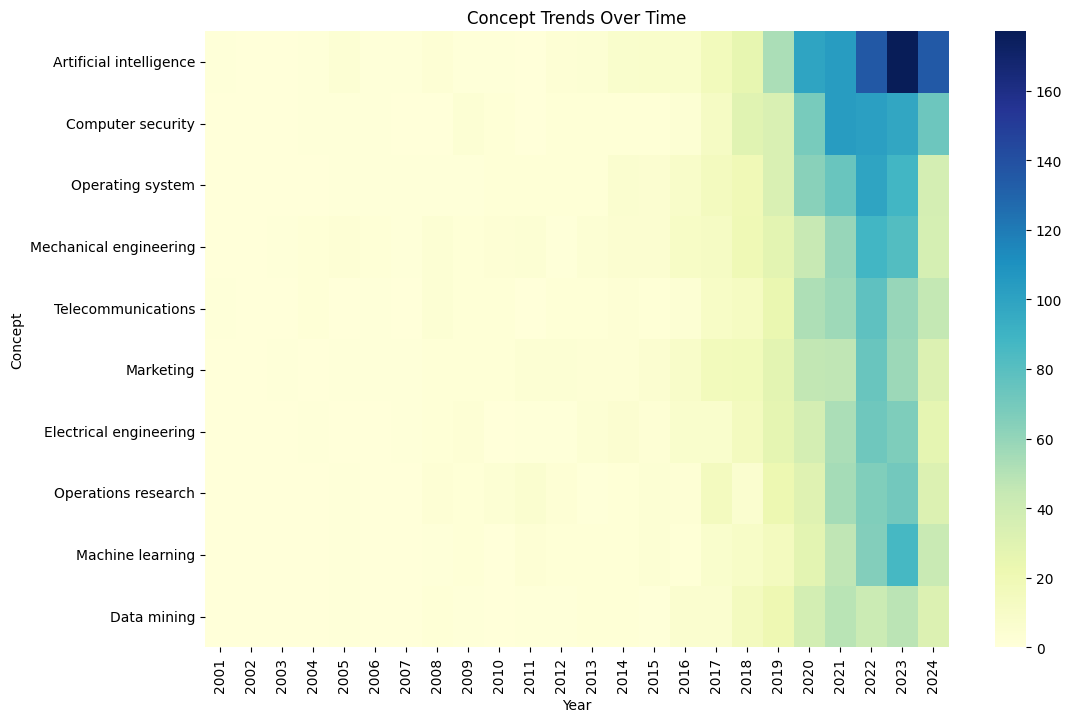

In [113]:
# Filter only top concepts
heatmap_data = concept_trends_ylim[['year'] + list(top_concepts)].set_index('year')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.T, cmap='YlGnBu', annot=False)
plt.title("Concept Trends Over Time")
plt.ylabel("Concept")
plt.xlabel("Year")
plt.show()

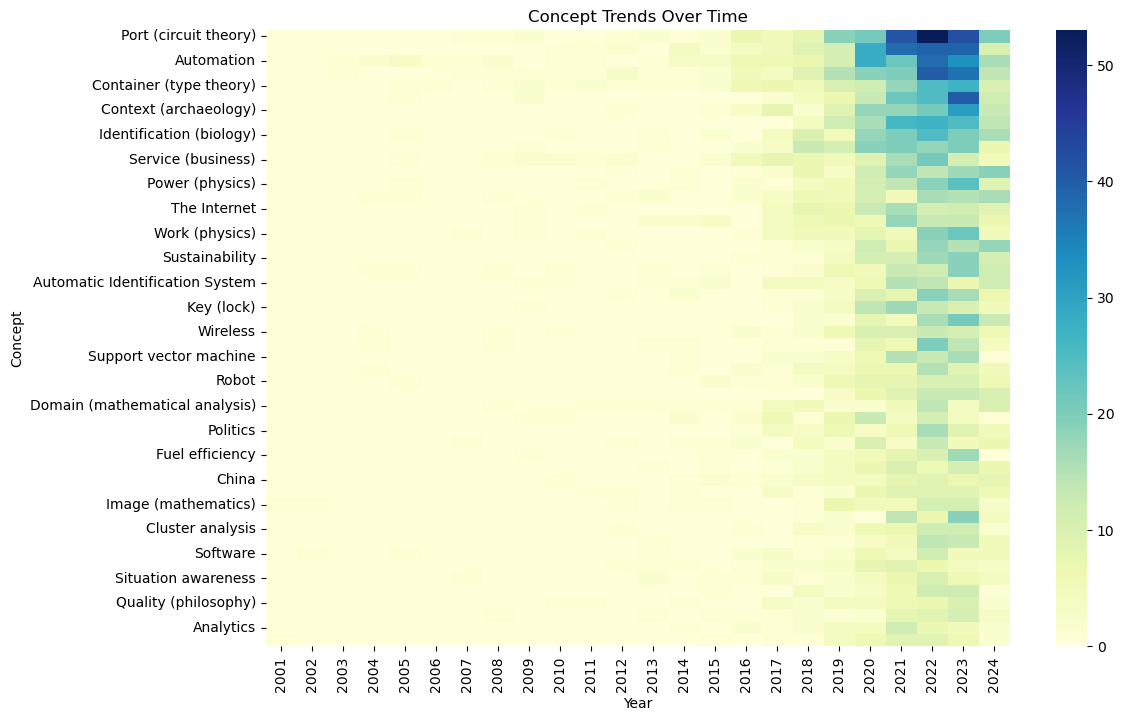

In [73]:
# We now expand on more to better highlight gaps in research

# Get the top N concepts overall
# filter on recent years if needed
year_min = 2000
concept_trends_ylim = concept_trends[concept_trends['year'] >= year_min]

N = 50
top_concepts = concept_trends_ylim.iloc[:, 1:].sum().sort_values(ascending=False).head(N).index

# Melt data for plotting
trend_melted = concept_trends_ylim.melt('year', var_name='Concept', value_name='Frequency')
trend_melted = trend_melted[trend_melted['Concept'].isin(top_concepts)]  # Filter top concepts

# Filter only top concepts
heatmap_data = concept_trends_ylim[['year'] + list(top_concepts)].set_index('year')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.T, cmap='YlGnBu', annot=False)
plt.title("Concept Trends Over Time")
plt.ylabel("Concept")
plt.xlabel("Year")
plt.show()